## CNN을 이용한 NLTK 영화 리뷰 분류

In [1]:
from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
# movei review data에서 file id를 가져옴
fileids = movie_reviews.fileids()

# file id를 이용해 raw text file을 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000   # 사용할 단어의 수
maxlen = 500    # 문서의 단어 수를 제한

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews) # 단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews)   # 만들어진 단어 인덱스를 이용해 문서들을 변환
X = pad_sequences(X, maxlen=maxlen, truncating='pre')

# label을 0, 1의 값으로 변환
label_dict={'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### 케라스를 이용해 CNN모형 생성

### 1번 컨볼루션 층
채널의 수 : 128개

필터의 크기 : 5

스트라이드 : 1 (한칸씩 이동)

### 2번 컨볼루션 층
채널의 수 : 256개

풀링 층 : 기본값

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    #word embedding layer 생성
    Embedding(max_words, 64, input_length=maxlen),
    Conv1D(128, # 채널의 수
           5,   # 1D 필터 크기
           padding = 'valid',
           activation='relu',
           strides=1),
    MaxPooling1D(),
    Conv1D(256,
           5,
           padding='valid',
           activation='relu',
           strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # binary logistic regression을 수행
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 64)           640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 128)          41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 122, 256)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31232)             0

2023-08-08 16:47:51.924213: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


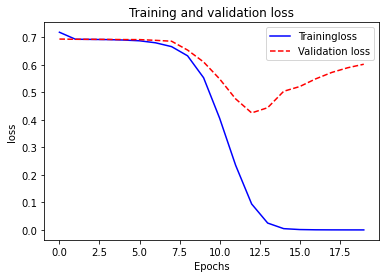

13/13 [==============================] - 0s 32ms/step - loss: 0.6319 - acc: 0.8225
#Test accuracy:0.822


In [6]:
adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2)

#학습 결과 그래프를 그린다.
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label="Training" + metric)
    plt.plot(history.history['val_'+metric], 'r--',  label='Validation ' + metric)
    plt.title('Training and validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'loss')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

### 결과

acc가 0.8225로 RNN, LSTM 모델에 비해 훨씬 높은 값을 보인다.

일반적으로 딥러닝을 수행할 때에는 손실값의 변화를 보면서 학습의 추이를 살펴본다.
학습의 추이가 위와 같이 시그모이드 함수의 좌우 반전된 모습과 같은 형태로 그려지면 학습 데이터에 대한 학습은 이상적으로 이루어지고 있다고 판단할 수 있다.